# Проект

---

Интернет-магазин ***«В один клик»*** продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.   

***«В один клик»*** — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

---

- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности:

> **«снизилась»**, если клиент стал покупать меньше товаров

> **«прежний уровень»**

- Нужно собрать данные по клиентам по **следующим признакам**:

> **Коммуникация сотрудников компании с клиентом** 

> **Продуктовое поведение покупателя** (какие товары покупает и как часто)

> **Покупательское поведение клиента** (сколько тратил в магазине)

> **Поведение покупателя на сайте** (как много страниц просматривает и сколько времени проводит на сайте)

---

Представим группы признаков (вместе с целевым) в виде **диаграммы Исикавы**:

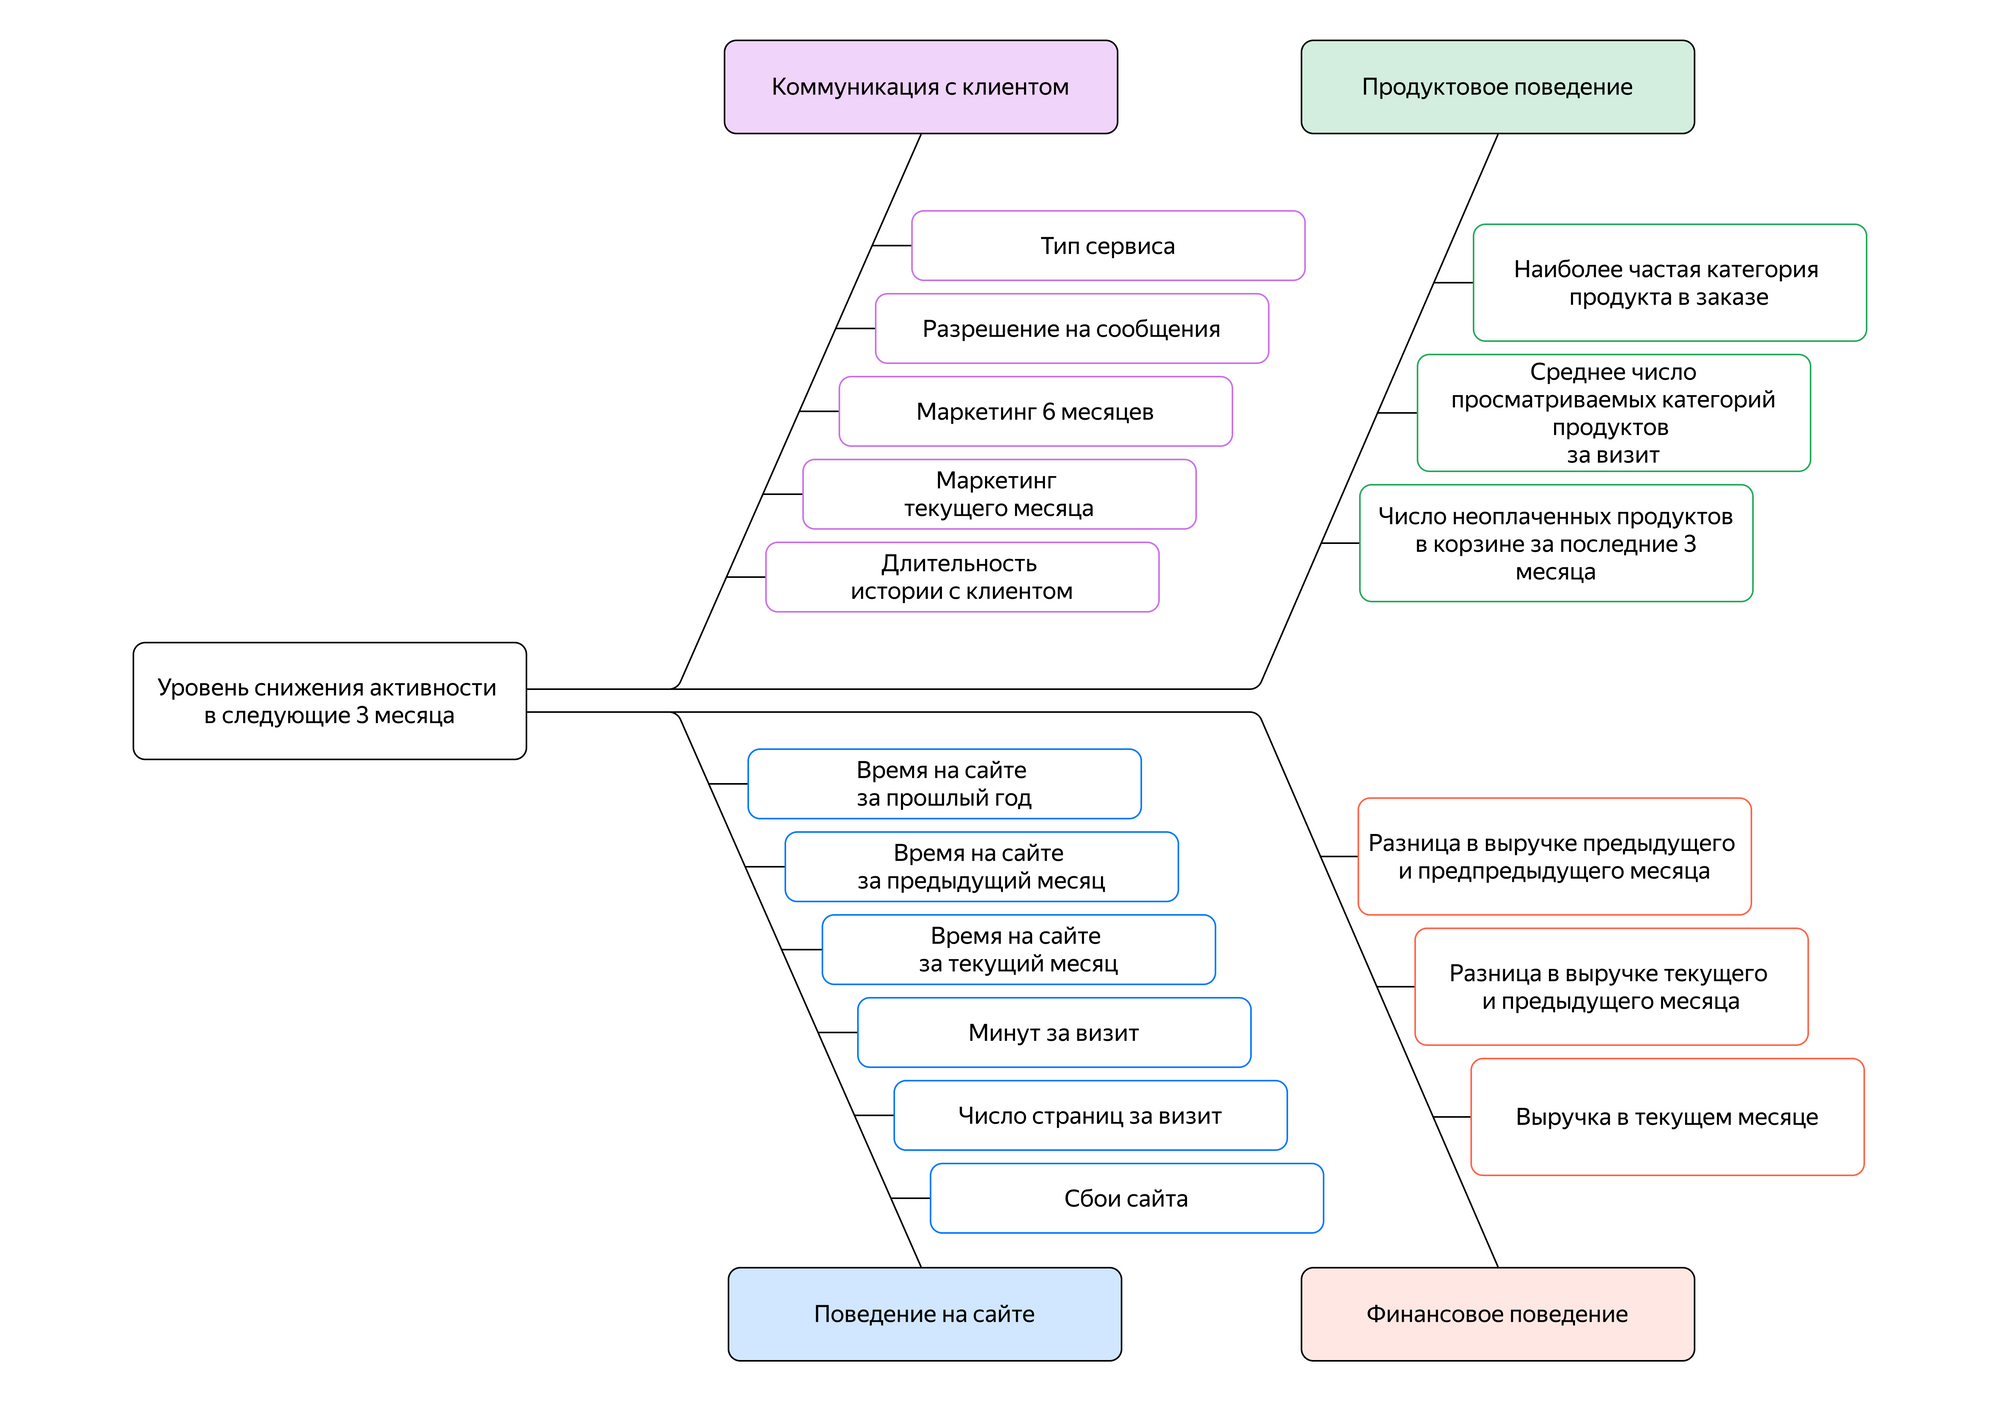

---

> Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца

> В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый 
покупатель приносил компании за последние три месяца

> Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения

---

# План работ

- [Шаг 1. Загрузка данных](#section_1)

- [Шаг 2. Предобработка данных](#section_2)

- [Шаг 3. Исследовательский анализ данных](#section_3)

- [Шаг 4. Объединение таблиц](#section_4)

- [Шаг 5. Корреляционный анализ](#section_5)

- [Шаг 6. Использование пайплайнов](#section_6)

- [Шаг 7. Анализ важности признаков](#section_7)

- [Шаг 8. Сегментация покупателей](#section_8)

- [Шаг 9. Общий вывод](#section_9)

---

<a id='section_1'></a>

## Загрузка данных

In [1]:
#Устанавливаем необходимые библиотеки:
!pip install shap
!pip install phik

In [2]:
#Импортируем библиотеки:
import shap
#Библиотеки для работы с табличными данными и массивами:
import pandas as pd
import numpy as np

#Библиотеки для графической иллюстрации:
import matplotlib.pyplot as plt
import seaborn as sns

#Библиотеки для корреляционного анализа:
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

#Библиотеки МО:

#Библиотеки для создания выборок:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Инструменты для создания пайплайнов:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Библиотеки для масштабирования и кодирования данных:
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler)

#Класс для работы с пропусками
from sklearn.impute import SimpleImputer

#необходимые метрики:
from sklearn.metrics import roc_auc_score, accuracy_score


#Модели МО:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Библиотеки оценки влияния признаков:
import shap
from sklearn.datasets import make_classification

#Библиотека для устранения исключений:
import warnings

In [3]:
#Считываем и распаковываем исходные данные, представленные в формате CSV:
#Считываем с сети:
try:
    #Файл содержащий данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
    df_market = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    
    #Файл с данными о выручке, которую получает магазин с покупателя:
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    
    #Файл с данными о времени (в минутах), которое покупатель провёл на сайте:
    df_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    
    #
    df_income = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')
    
#В случае изменения ссылки или отсутсвия сети:
except:
    df_market = pd.read_csv('/datasets//market_file.csv')
    
    df_money = pd.read_csv('/datasets/market_money.csv')
    
    df_time = pd.read_csv('/datasets/market_time.csv')
    
    df_income = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
    
#Используем специальную команду отображения таблиц, для наглядного просмотра всех данных:    
pd.set_option('display.max_columns', None)

In [4]:
#Создадим список, в который положим все исходные датафреймы:
all_df = [df_market, df_money, df_time, df_income]

#С помощью цикла просмотрим все данные о каждой таблице:
for df in all_df:    
    display(df.head(10))
    print()
    df.info()
    print()
    print('-'*125)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса               

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

-----------------------------------------------------------------------------------------------------------------------------


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

-----------------------------------------------------------------------------------------------------------------------------


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

-----------------------------------------------------------------------------------------------------------------------------


Итак, все данные выгружены. Можно просмотреть все типы данных и соответсвующие им значения в столбах датафреймов. Соответвие типов **не нарушается**. Требуется проверка корректности строковых и числовых данных таблиц, которая будет проведена на следующем этапе. На данном этапе можем обозначить размерности полученных датафреймов:

> ***df_market*** | количество строк **1300** | количество столбцов **13**

> ***df_money*** | количество строк **3900** | количество столбцов **3**

> ***df_time*** | количество строк **2600** | количество столбцов **3**

> ***df_income*** | количество строк **1300** | количество столбцов **2**

Исходя из данных столбцов, можно сделать несколько выводов:

- Все датафреймы имеют столбец ***id*** - он является общим, по нему можно производить соединение и сортировку данных

- Датафреймы ***df_market*** и ***df_income*** - имеют одинаковое количество строк

- Самый большой датафрейм по количеству признаков (столбцов) - это ***df_market***

- Самый большой датафрейм по количеству строк - это ***df_money***

<a id='section_2'></a>

## Предобработка данных

Создадим функцию ***check*** до/после обработки данных, для отслеживания процента потерянных данных после обработки:

In [5]:
#Обозначим глобальную переменную, в которой сохраним исходное количество строк всех таблиц:
s=0
for i in all_df:
    s+=i.shape[0]

#Функция check
def check(all_data):
    s_after = 0
    for i in all_data:
        s_after += i.shape[0] 
    print(f'Количество удаленных строк: {s - s_after}')
    print(f'Процент потерянных данных от общего числа: {(1 - s_after/s)*100:.2f}%')
    pass

#Вызовем функцию и проверим работу (с помощью этой функции в конце оценим процент удаленных данных)
check(all_df)

Количество удаленных строк: 0
Процент потерянных данных от общего числа: 0.00%


### Просмотр строковых значений

In [6]:
#Приведем названия столбцов и все строковые значения к нижнему регистру во всех датафреймах:

#Пробегаемся по всем датафреймам:
for df in all_df:
    
    #Приводим все столбцы к нижнему регистру:
    df.columns = df.columns.str.lower()
    
    #Меняем все названия столбцов в которых есть ' ' на '_':
    for col_name in df.columns:
        if ' ' in col_name:
            new_col = col_name.replace(' ', '_')
            df.rename(columns={col_name: new_col}, inplace=True)
          
    #Приводим все значения во всех таблицах к нижнему регистру
    for col in df:
        if type(df[col].values[0]) == str:
            df[col] = df[col].str.lower()

In [7]:
#Создадим функцию для просмотра уникальных категориальных значений по всем столбцам исходных датафреймов:
def uniq():
    k = 1
    for name in all_df:
        for col in name:
            if type(name[col].values[0]) == str:
                print(f'Датафрейм №{k}')
                print(f'Имя столбца: {col}')
                print(name[col].unique())
                print()
        k+=1
        pass
    
#Вызовем функцию:
uniq()

Датафрейм №1
Имя столбца: покупательская_активность
['снизилась' 'прежний уровень']

Датафрейм №1
Имя столбца: тип_сервиса
['премиум' 'стандартт' 'стандарт']

Датафрейм №1
Имя столбца: разрешить_сообщать
['да' 'нет']

Датафрейм №1
Имя столбца: популярная_категория
['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']

Датафрейм №2
Имя столбца: период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Датафрейм №3
Имя столбца: период
['текущий_месяц' 'предыдцщий_месяц']



---
Просматривая строковые данные были обнаружены некоторые ошибки:

- В датафрейме ***df_market*** в столбце **"тип_сервиса"** имеются значения с ошибками - ***стандартт*** (удвоенная буква "Т")

- В датафрейме ***df_market*** в столбце **"популярная_категория"** имеются значения с ошибками (в строках **"косметика и аксесуары"** слово "аксесуары" должно иметь удвоенную букву **С** - ***аксессуары***)

- Требуется проверка слов **"препредыдущий_месяц"** - не является ли это значение идентичным к **"предыдущий_месяц"** (***df_money***)

- В датафрейме ***df_time*** в столбце **"период"** имеются значения с ошибками - слово "предыдцщий", неправильный набор с клавиатуры (перепутаны буква "**у**" с буквой "**ц**")

Требуется проверить и исправить все выявленные выше неточности

---

In [8]:
#Изменяем все явные ошибки:
df_market['тип_сервиса'] = df_market['тип_сервиса'].replace('стандартт', 'стандарт')

df_market['популярная_категория'] = df_market['популярная_категория'].replace('косметика и аксесуары', 'косметика и аксессуары')

df_time['период'] = df_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

#Просмотрим значение "препредыдущий" и "предыдущий":
df_money.value_counts('период')

период
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
dtype: int64

---
- [x] С этим значением все в порядке, поскольку данные переданы за 3 месяца работы сервиса, их равное количество, значит значение "препредыдущий" - **обозначает 2 месяца назад**

---

In [9]:
#Вызовем функцию uniq(), сделаем проверку и убедимся, что все исправления вступили в силу:
uniq()

Датафрейм №1
Имя столбца: покупательская_активность
['снизилась' 'прежний уровень']

Датафрейм №1
Имя столбца: тип_сервиса
['премиум' 'стандарт']

Датафрейм №1
Имя столбца: разрешить_сообщать
['да' 'нет']

Датафрейм №1
Имя столбца: популярная_категория
['товары для детей' 'домашний текстиль' 'косметика и аксессуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']

Датафрейм №2
Имя столбца: период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Датафрейм №3
Имя столбца: период
['текущий_месяц' 'предыдущий_месяц']



> Все строковые значения были проверены, все ошибки определены и исправлены

### Работа с пропусками

In [10]:
#Проверим наличие пропусков во всех датафреймах:
for df in all_df:
    print(df.isna().sum())
    print()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

id         0
период     0
выручка    0
dtype: int64

id        0
период    0
минут     0
dtype: int64

id         0
прибыль    0
dtype: int64



> По результатам проверки все датафреймы оказались **без пропусков**

### Поиск дубликатов

In [11]:
#Проверка на наличие явных дубликатов:
for df in all_df:
    print(df.duplicated().sum())
    print()

0

0

0

0



> По результатам проверки во всех датафреймах **явных дубликатов не нашлось**

In [12]:
#Количество уникальных значений ***id*** по всем датафреймам:
for df in all_df:
    print(df['id'].nunique())

1300
1300
1300
1300


In [13]:
#Просмотрим неявные дубликаты:

#Рассмотрим все значения без ***id*** (т.к. id уникален)
df_market.loc[df_market.duplicated(list(df_market.columns)[1:]) == True]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
547,215895,снизилась,стандарт,нет,4.4,5,517,0.23,товары для детей,1,2,5,11
548,215896,снизилась,стандарт,нет,4.3,4,460,0.16,техника для красоты и здоровья,2,1,3,6
549,215897,снизилась,стандарт,да,3.9,4,627,0.24,товары для детей,3,3,7,8
550,215898,снизилась,стандарт,да,5.5,4,703,0.14,мелкая бытовая техника и электроника,2,1,3,7
551,215899,снизилась,стандарт,нет,5.0,4,136,0.27,товары для детей,3,4,4,17
552,215900,снизилась,стандарт,да,4.8,4,907,0.30,косметика и аксессуары,2,1,1,6
553,215901,снизилась,стандарт,нет,3.9,5,600,0.17,домашний текстиль,1,7,4,10
554,215902,снизилась,стандарт,да,3.3,3,871,0.20,техника для красоты и здоровья,2,4,2,17
555,215903,снизилась,стандарт,да,5.6,5,574,0.28,домашний текстиль,3,2,3,9
556,215904,снизилась,премиум,да,5.5,5,982,0.94,мелкая бытовая техника и электроника,3,1,8,10


> Итак найдено 11 неявных дублей (не учитывая столбец ***id***) в датафрейме ***df_market***

Решение об их удалении пока **отложим**, т.к. количество уникальных пользователей во всех датафреймах одинаковое. Полученные значения идут подряд начиная с 547 индекса и заканчивая 557 индексом. Скорей всего была допущена ошибка, кто-то продублировал уже занесенные значения

In [14]:
#Проверка потерянных данных после предобработки:
check(all_df)

Количество удаленных строк: 0
Процент потерянных данных от общего числа: 0.00%


По результатам предобработки данных:

> **Пропусков нет**

> **Дубликатов нет**

> Найдены **11 неявных дубликатов** в ***df_market*** - решение об их удалении отложили, т.к. уникальных значений по ***id*** во всех датафреймах соответсвует **1300**

> Соответсвие типов значений числовых было рассмотрено на первом этапе (по средствам ***df.info()***) - все числовые значения имеют **корректные типы** ***ind*** и ***float***

<a id='section_3'></a>

## Исследовательский анализ данных

### Анализ df_market

In [15]:
#Посмотрим общие статистические характеристики для всех числовых столбцов датафрейма df_market:
df_market.describe().style.format("{:,.4f}")

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,"1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000"
mean,"215,997.5000",4.2538,4.0115,601.8985,0.3198,3.2700,2.8400,4.1854,8.1769
std,375.4220,1.0148,0.6969,249.8563,0.2498,1.3554,1.9715,1.9553,3.9781
min,"215,348.0000",0.9000,3.0000,110.0000,0.0000,1.0000,0.0000,0.0000,1.0000
25%,"215,672.7500",3.7000,4.0000,405.5000,0.1700,2.0000,1.0000,3.0000,5.0000
50%,"215,997.5000",4.2000,4.0000,606.0000,0.2400,3.0000,3.0000,4.0000,8.0000
75%,"216,322.2500",4.9000,4.0000,806.0000,0.3000,4.0000,4.0000,6.0000,11.0000
max,"216,647.0000",6.6000,5.0000,"1,079.0000",0.9900,6.0000,10.0000,9.0000,20.0000


#### Частотные гистограммы

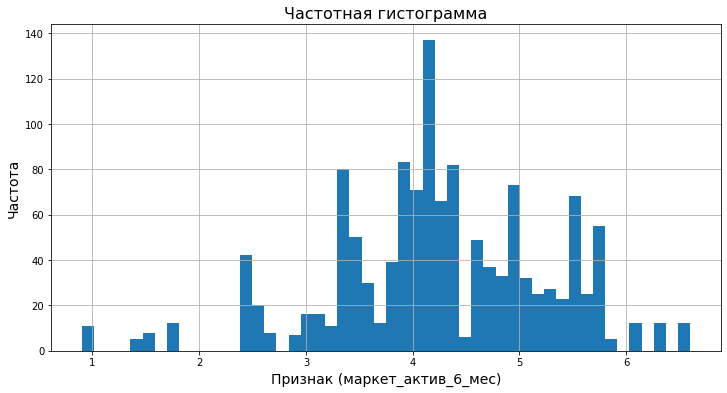

Мода признака: 4.1



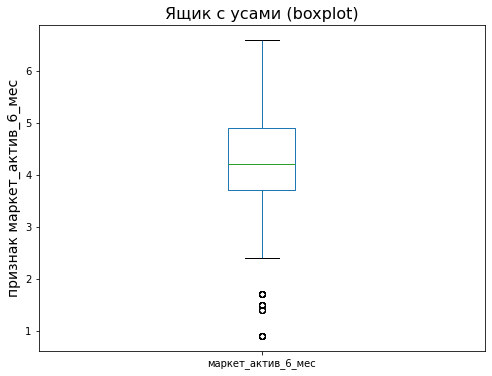

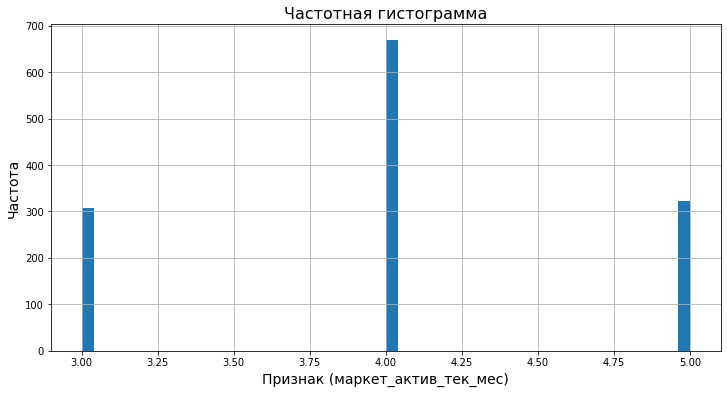

Мода признака: 4



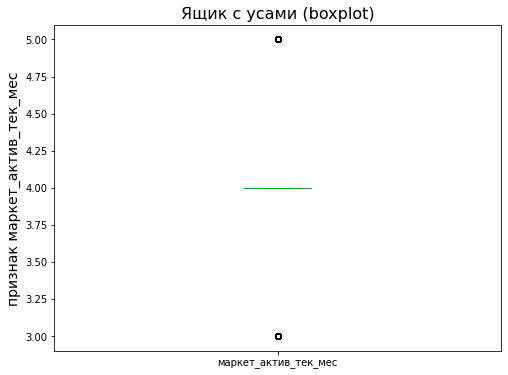

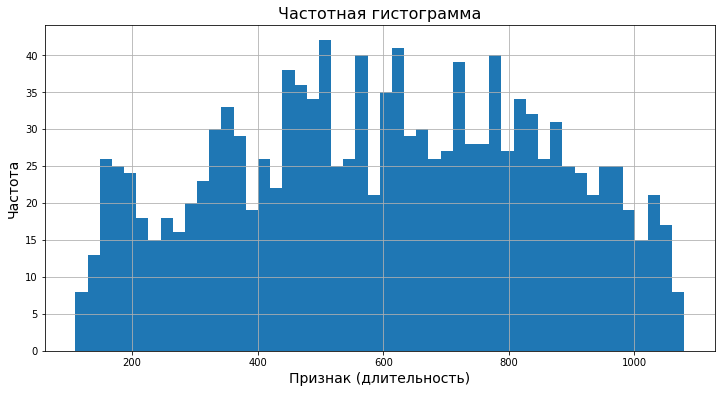

Мода признака: 449



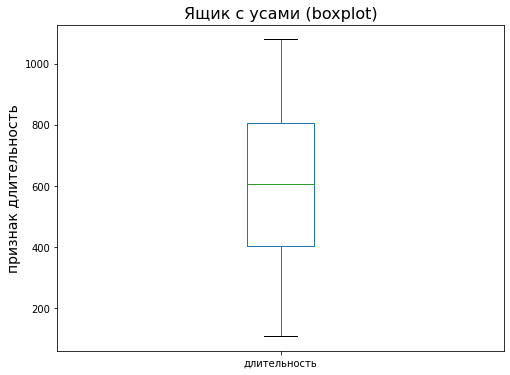

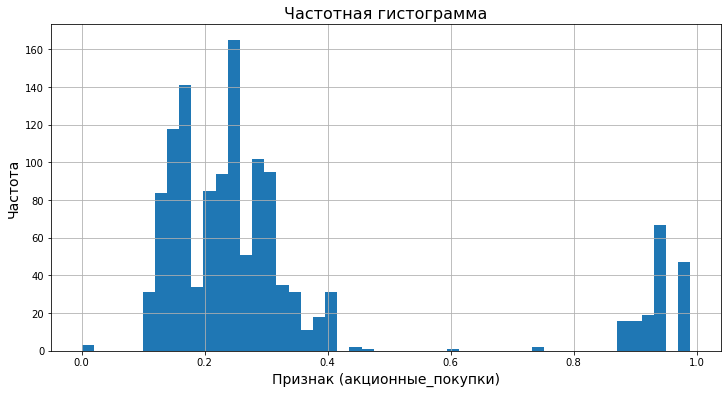

Мода признака: 0.24



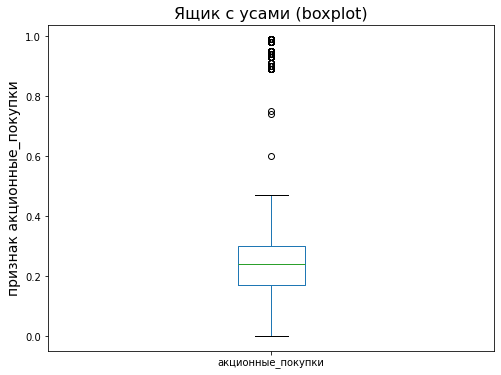

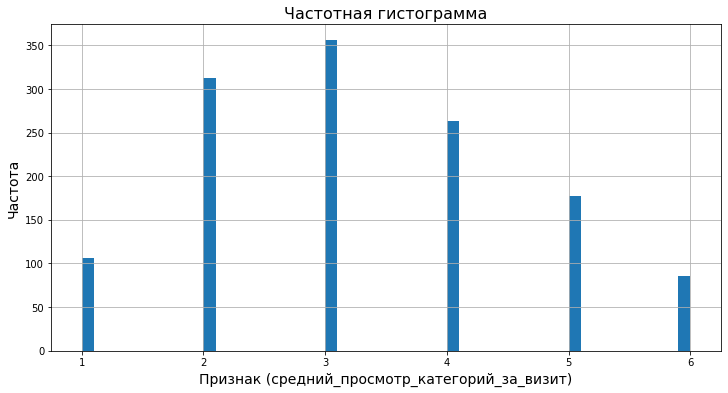

Мода признака: 3



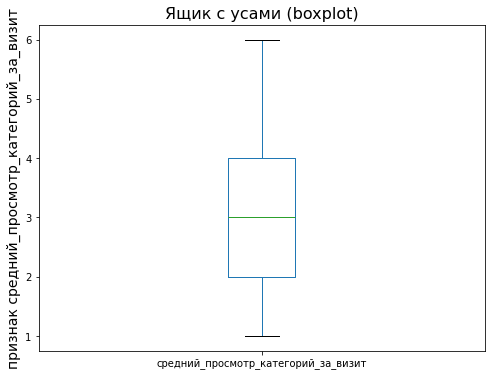

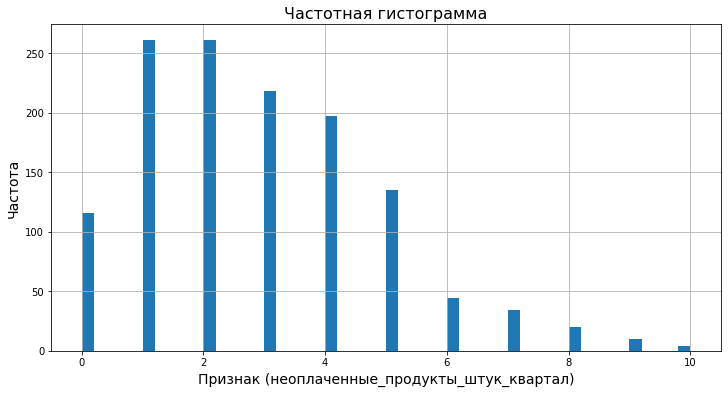

Мода признака: 1



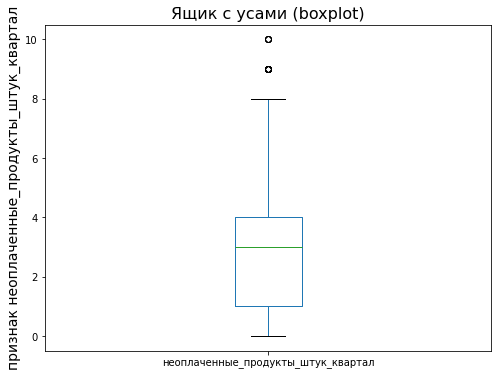

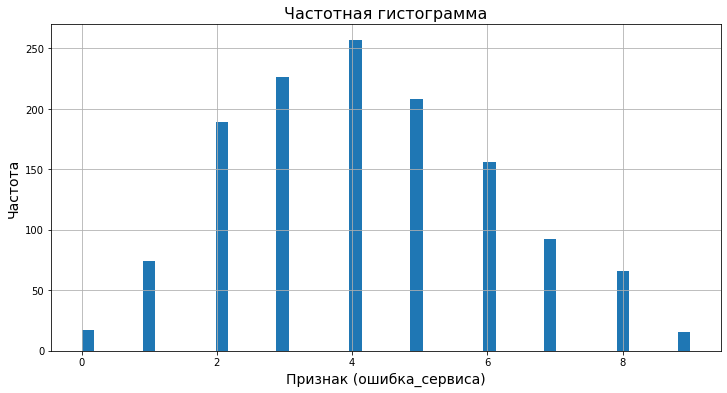

Мода признака: 4



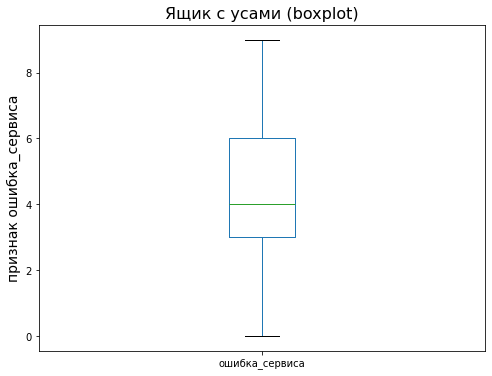

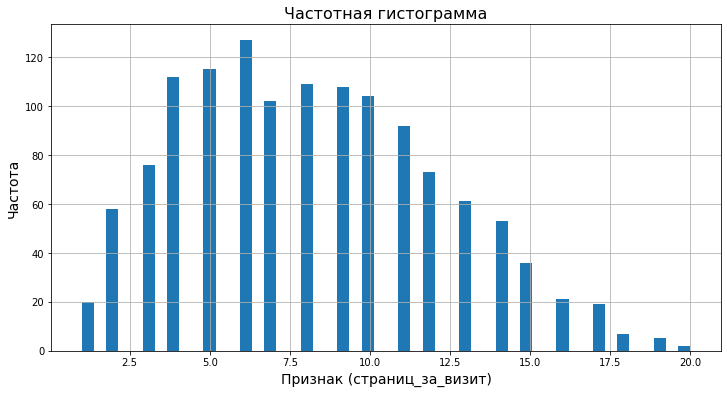

Мода признака: 6



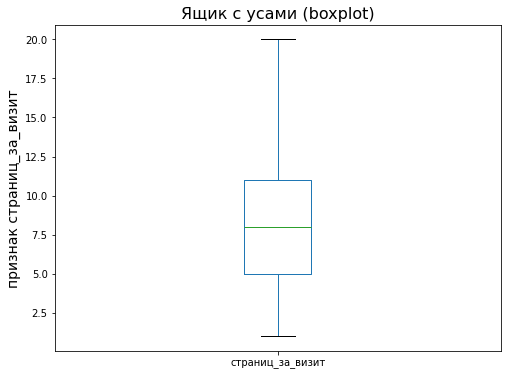

In [16]:
#Создадим функцию для построения частотных гистограмм:
def graph(df, bins):
    
    #Перебираем все имена с количественными столбцами без учета id:
    for name in df.select_dtypes(include='number').columns.tolist()[1:]:
                
        #Строим гистограммы в цикле:
        plt.figure(figsize=(12,6))
        df[name].plot(kind='hist', bins=bins, grid=True)
        plt.xlabel(f'Признак ({name})', fontsize=14)
        plt.ylabel('Частота', fontsize=14)
        plt.title('Частотная гистограмма', fontsize=16)
        plt.show()
        print(f'Мода признака: {df[name].mode()[0]}')
        print()
        
        #Строим боксплоты в цикле:
        plt.figure(figsize=(8,6))
        df[name].plot(kind='box')
        plt.xlabel('', fontsize=14)
        plt.ylabel(f'признак {name}', fontsize=14)
        plt.title('Ящик с усами (boxplot)', fontsize=16)
        plt.show()

#Вызовем функцию для первого датафрейма: (количество корзин можно менять, если потребуется)
graph(df_market, 50)

По построенным гистограмма частотности можно сказать:

> Поскольку некоторые количественные значения **дискретны** (целые числа) - их гистограммы частотности имеют **интервалы с пропусками**

> Большенство данных распределено **нормально** (некоторые смещены)

> Выбивающихся аномальных значений - нет. Все данные лежат в разумном диапозоне

> Из всех гистограмм нормальное распределение плохо прослеживается у признака **"акционные_покупки"** - гистограмма имеет две выпуклости с большим интервалом пропуска. **не будем удалять данные, т.к. скорей всего это проценты распределенные от 0 до 1** - значит со значениями проблем нет

> Также анализируя выбросы на боксплотах, можно увидеть, что данные в признаке **акционные покупки** - имеют больше всего выбросов

> Большестно признаков имеют маленькое количество выбросов или не имеют их совсем

#### Анализ категориальных данных

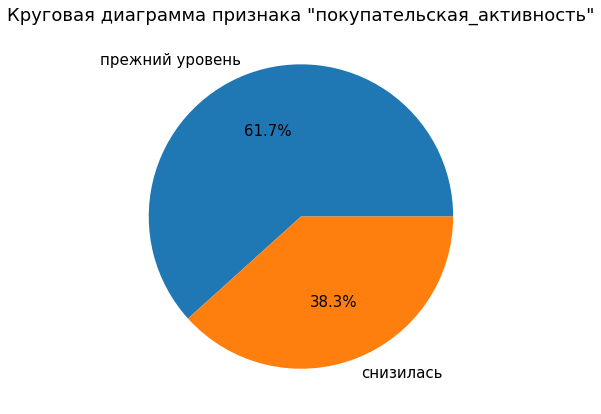

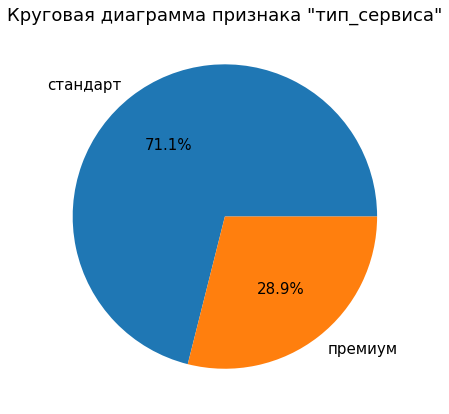

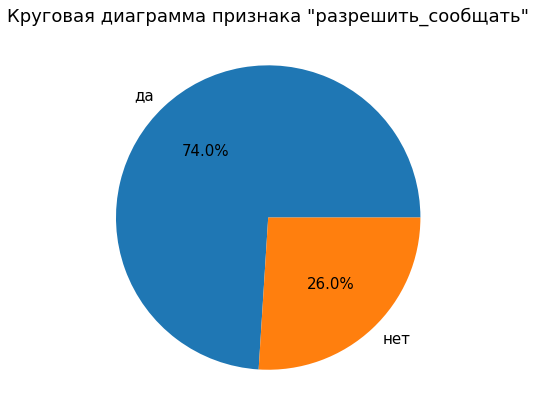

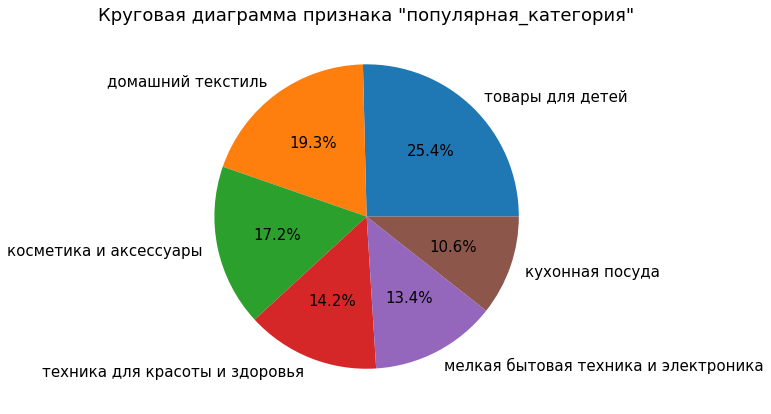

In [17]:
#Создадим функцию для построения круговых диаграмм, чтобы оценить соотношение категориальных признаков:
def graph_cat(df):
    for name in df.select_dtypes(include='object').columns.tolist():
        df[name].value_counts().plot(kind='pie', figsize=(7,7), autopct='%1.1f%%', fontsize=15)
        plt.ylabel('')
        plt.title(f'Круговая диаграмма признака "{name}"', size=18)
        plt.show()
        print()

#Вызовем функцию:        
graph_cat(df_market)

> С соотношениями категориальных признаков все хорошо, оценить долю каждого уникального значения можно по диаграммам

### Анализ df_money

In [18]:
#Статистические характеристики:
df_money.describe().style.format("{:,.4f}")

,id,выручка
count,"3,900.0000","3,900.0000"
mean,"215,997.5000","5,025.6961"
std,375.3257,"1,777.7041"
min,"215,348.0000",0.0000
25%,"215,672.7500","4,590.1500"
50%,"215,997.5000","4,957.5000"
75%,"216,322.2500","5,363.0000"
max,"216,647.0000","106,862.2000"


#### Частотные гистограммы

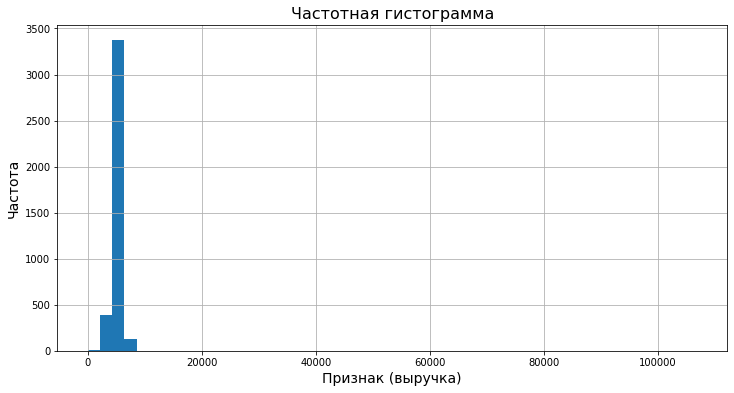

Мода признака: 4729.0



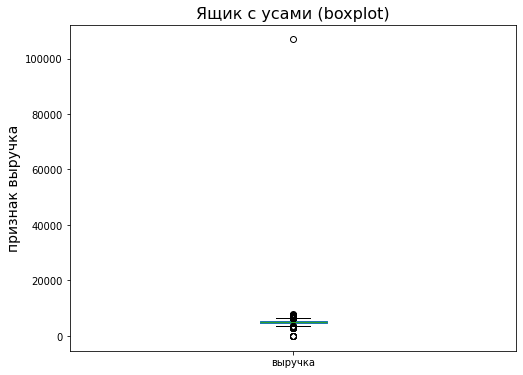

In [19]:
#Вызовем фкнуцию для построения графиков количественных переменных:
graph(df_money, 50)

> В данных имеется **аномалия**, на графике частотной гистограммы имеются значения порядка ста тысяч при медиане пять тысяч

> Также эту аномалию можно проследить на графике боксплота

> Значения равные 0 - нормальные значения, которые говорят о том, что клиент ничего не приобрел в данный месяц

In [20]:
#просмотрим аномальное значение:
df_money['выручка'].max()

106862.2

In [21]:
df_money.loc[df_money['выручка']==106862.2]['id']

98    215380
Name: id, dtype: int64

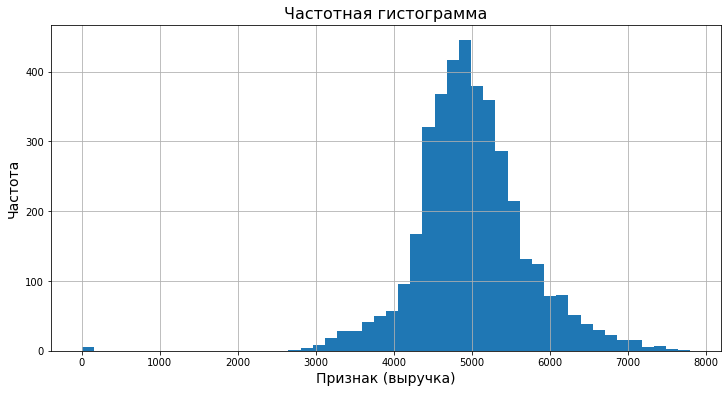

Мода признака: 4729.0



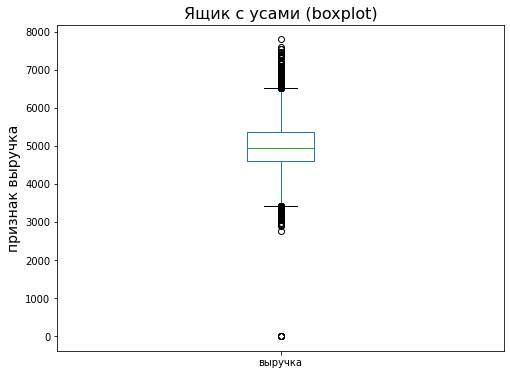

In [22]:
#С помощью среза уберем данное знаечние:
df_money = df_money.query('выручка < 10000')

#Вызовем функцию снова:
graph(df_money, 50)

> Распределение похоже на **нормальное**, немного смещенное влево, относительно мат.ожидания

> Есть выброс в нуле судя по графику боксплота - но это нормальное значение, ведь выручка может быть равна 0

> Интервал признака - корректный

#### Анализ категориальных данных

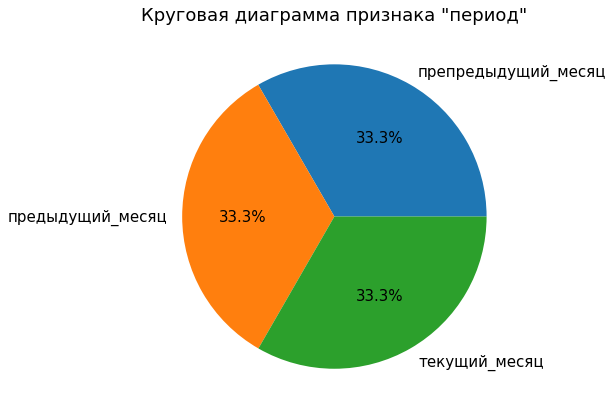

In [23]:
#Доля уникальных знаечний категориального признака df_money
graph_cat(df_money)

> Тут все в порядке, количество месяцев 3 - имеется информация по всем трем месяцам (в равных пропорциях)

### Анализ df_time

#### Частотные гистограммы

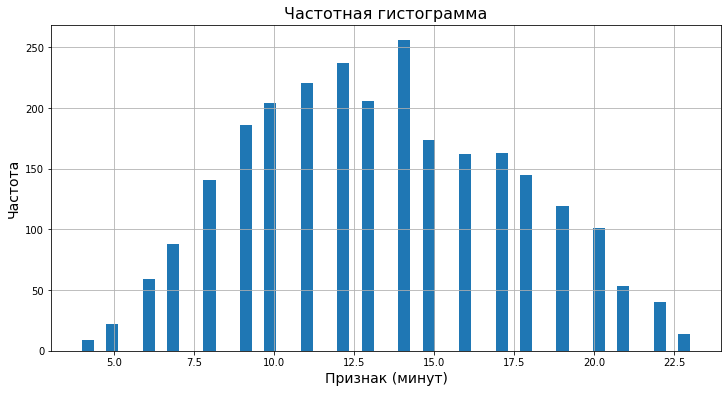

Мода признака: 14



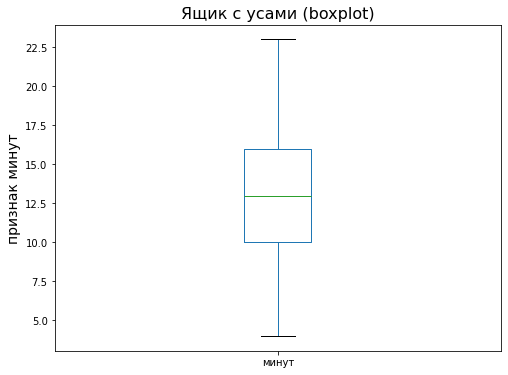

In [24]:
graph(df_time, 50)

> Распределение схоже с **нормальным**

> Выбросов - нет

#### Анализ категориальных данных

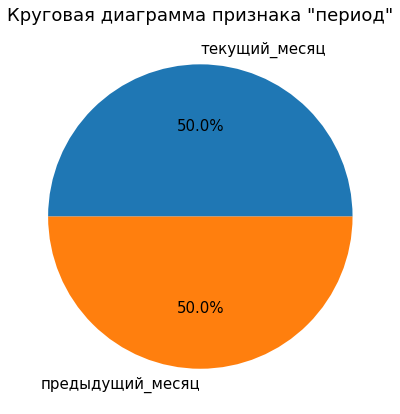

In [25]:
graph_cat(df_time)

### Анализ df_income

#### Частотные гистограммы

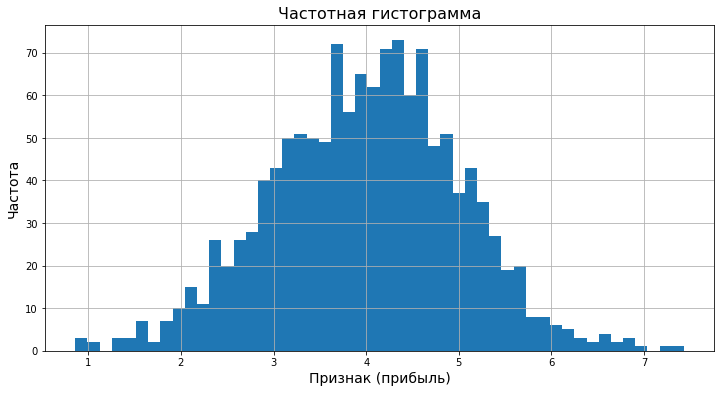

Мода признака: 3.89



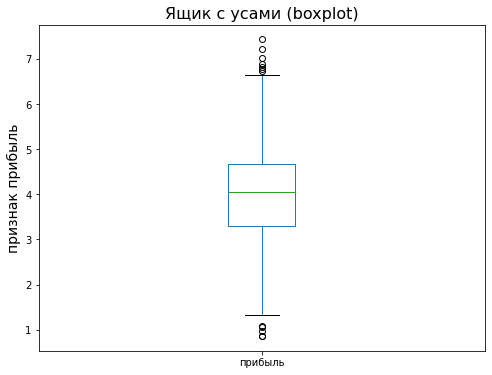

In [26]:
graph(df_income, 50)

> Распределение схоже с **нормальным**

> Категориальных данных в таблице ***df_income*** - **нет**

> Анализирую боксплот - выбросы есть, но лежат они в допустимом диапозоне

### Отбираем клиентов

Требуется отобрать клиентов, которые совершают покупки каждый месяц. Для этого рассмотрим датафрейм df_money:

In [27]:
df_money.head(10)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


В вызванном датафрейме имеются клиенты (по id), чья выручка равна 0, таких клиентов нужно исключить из данных. Для этого создадим переменную, в которую положим булевы значения, а после исключим их:

In [28]:
#Сделаем это таким способом:
zero_profit = df_money.groupby('id')['выручка'].apply(lambda x: (x == 0).any())

#пример вывода:
df_money.groupby('id')['выручка'].apply(lambda x: (x == 0).any())

id
215348     True
215349    False
215350    False
215351    False
215352    False
          ...  
216643    False
216644    False
216645    False
216646    False
216647    False
Name: выручка, Length: 1300, dtype: bool

In [29]:
#Создадим новый датафрейм, в котором не будет даных id (в который встречается в выручке значение **0**)
df_profit = df_money[~df_money['id'].isin(zero_profit[zero_profit].index)]

#Также удалим значения id = 215380 - это значение, в котором присутсвовала 1 аномалия, значит теперь одно из трех - пустое
d = df_profit[df_profit['id'] == 215380].index
df_money = df_profit.drop(d)

#Выведем его:
df_money

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


> В сводной таблице хранятся сгруппированные ***id*** клиентов, которые имели **покупательскую активность** в каждом из трех месяцев

**Результаты исследовательского анализа данных:**

> Построены все гистограммы частотности для всех количественных признаков

> Построены круговые диаграммы для всех категориальных признаков

> Большенство количественных данных имеют **нормальное распределение**

> Удалено аномальное значение с *id = 215380* из ***df_money***

В отдельную таблицу поместили клиентов, которые имели покупательскую активность в каждом месяце из трех представленных

<a id='section_4'></a>

## Объединение таблиц

Объединим таблицы df_market, df_money, df_time, для этого:

In [30]:
#На данном этапе датафрейм df_money имеет такой вид:
df_money

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


Требуется сгруппировать все значения по индексам, значение столбца "период" представить в виде трех столбцов по выручке

In [31]:
df_money = df_money.pivot(index='id', columns='период', values='выручка').reset_index()
df_money.columns.name = None
df_money = df_money.rename(columns={'предыдущий_месяц':'выручка_пред_мес', 
                        'препредыдущий_месяц':'выручка_препред_мес', 
                        'текущий_месяц':'выручка_тек_мес'})

#Выведем получившуюся таблицу:
df_money

,id,выручка_пред_мес,выручка_препред_мес,выручка_тек_мес
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1291,216643,3664.0,4704.0,4741.7
1292,216644,4729.0,5299.0,5353.0
1293,216645,5160.0,5334.0,5139.2
1294,216646,4923.0,4725.0,5224.6


Аналогичную процедуру проведем с датафреймом df_time:

In [32]:
df_time = df_time.pivot(index='id', columns='период', values='минут').reset_index()
df_time.columns.name = None
df_time = df_time.rename(columns={'предыдущий_месяц':'мин_на_сайте_пред_мес',                          
                        'текущий_месяц':'мин_на_сайте_тек_мес'})

#Выведем получившуюся таблицу:
df_time

,id,мин_на_сайте_пред_мес,мин_на_сайте_тек_мес
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


> Получили две таблицы, которые можно соединить с исходной df_markert

Перед соединением таблиц нужно провести проверку размерности исходных датафреймов:

Поскольку соединять дф будем по id, методом inner - итоговый результат должен отсечь аномальное значение и пропуски, которые мы нашли ранее в df_money. Следовательно количество строк в итоговом ДФ должно соответствовать наименьшему значению среди всех дф после объединения:

In [33]:
#количество строк:
min(df_money.shape[0], df_time.shape[0], df_market.shape[0])

#Количество столбцов должно быть уменьшенно на 1 в датафреймах df_money и df_time - т.к. объединяем не по индексу, а по id
#Следовательно итоговое количество столбцов:
df_money.shape[1]-1 + df_time.shape[1]-1 + df_market.shape[1]

#откуда получаем, что размерность итогового df, должна быть:
print(f'количество строк: {min(df_money.shape[0], df_time.shape[0], df_market.shape[0])}')
print(f'количество стоблцов: {df_money.shape[1]-1 + df_time.shape[1]-1 + df_market.shape[1]}')

количество строк: 1296
количество стоблцов: 18


In [34]:
#Добавляем к df_market датафрейм df_money по id (включая только те, которые имеются в обоих фреймах "inner")
df = pd.merge(df_market, df_money, on='id', how='inner')

#К полученному df - добавляем df_time аналогичным способом:
df = pd.merge(df, df_time, on='id', how='inner')

#Вызываем df, смотрим на результат:
df

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,выручка_препред_мес,выручка_тек_мес,мин_на_сайте_пред_мес,мин_на_сайте_тек_мес
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,прежний уровень,стандарт,да,6.6,3,318,0.24,техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1292,216644,прежний уровень,стандарт,нет,5.1,4,454,0.21,домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1293,216645,прежний уровень,стандарт,да,4.1,3,586,0.20,домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1294,216646,прежний уровень,стандарт,да,6.3,5,645,0.12,техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [35]:
#Итоговый df должен иметь размерность 1296x18, выполним проверку:
df.shape

(1296, 18)

In [36]:
#Проверка на наличие явных дубликатов после объединения
df.duplicated().sum()

0

> Мы получили ***df*** - которых содержит данные всех трех датафреймов ***df_market, df_money, df_time***

> ***df*** - имеет размерность **(1296x18)**

В исходный датафрейм ***df_market*** добавилось **5 признаков** - выручка за каждый из трех месяцев, а также время проведенной на сайте за текущий и предыдущий месяц

> Объединение таблиц делали с помошью ***inner*** - для включения только тех знаечний, которые есть в обоих дф, с помощью такой процедуры мы отобрали **активных покупателей** (у который выручка в каждом месяце отлична от 0) и убрали одного клиента с аномальным знаечнием выручки

> Изначальное количество пользователей составляло 1300, итоговая таблица содержит 1296 строк, следовательно мы исключили из данных информацию о 4 пользователях, для дальнейшего анализа - это не критично, т.к. процент потерянных данных (приемлемый) может состовять 5-10%

<a id='section_5'></a>

## Корреляционный анализ

In [37]:
#Создаем список непрерывных переменных:
interval_cols = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_пред_мес', 'выручка_препред_мес',
                 'выручка_тек_мес', 'мин_на_сайте_пред_мес', 'мин_на_сайте_тек_мес']

#Матрица корреляции по phik для итогового дф (без учета столбца id):
df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,выручка_препред_мес,выручка_тек_мес,мин_на_сайте_пред_мес,мин_на_сайте_тек_мес
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.405041,0.224154,0.747331,0.224638,0.497393,0.197213,0.685138,0.576770
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.113015,0.079515,0.087776,0.000000,0.069704,0.124216,0.131814,0.000000
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.162524,0.021839,0.097094,0.080842,0.000000,0.060907,0.038387,0.000000
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.217731,0.142401,0.376035,0.155476,0.315331,0.039795,0.363950,0.330601
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.142887,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.128222,0.175608,0.128089,0.125572,0.113200,0.147048,0.026448,0.101481
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.246665,0.000000,0.350714,0.060733,0.226381,0.071094,0.262324,0.250558
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.254746,0.000000,0.177637,0.252097,0.043528,0.237240,0.195233,0.089883
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.334927,0.070315,0.293781,0.098440,0.176828,0.092597,0.159837,0.182568
неоплаченные_продукты_штук_квартал,0.405041,0.113015,0.162524,0.217731,0.142887,0.128222,0.246665,0.254746,0.334927,1.000000,0.000000,0.310843,0.193536,0.189320,0.166017,0.197933,0.168998


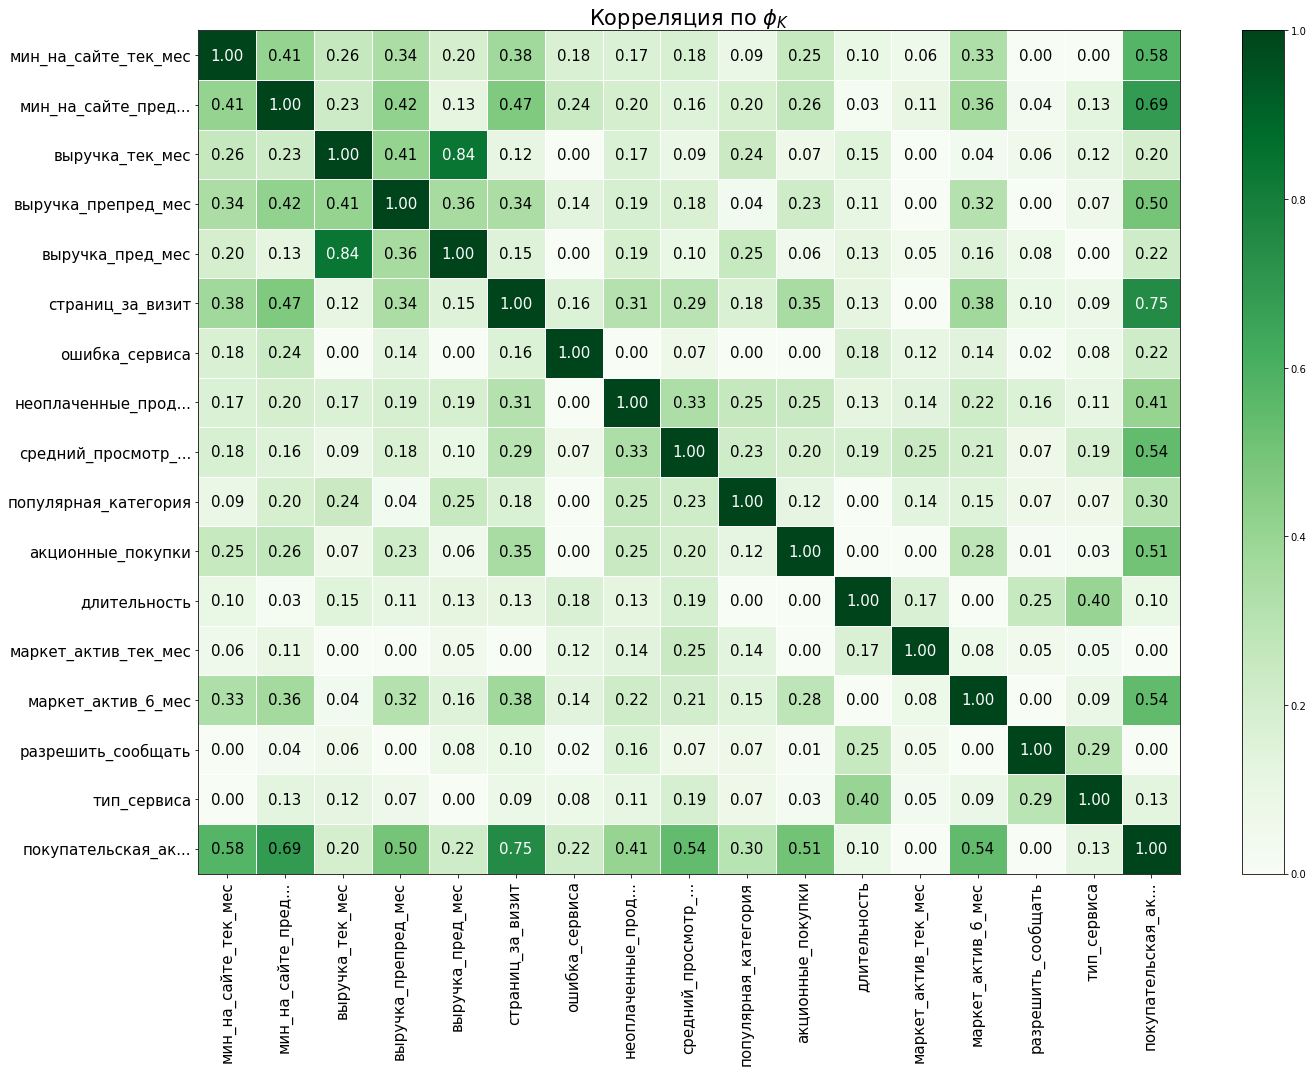

In [38]:
#Удобнее будет представить данную матрицу графически

#Считаем корреляции данных:
phik_overview = phik_matrix(df.drop('id', axis=1), interval_cols=interval_cols)

#Строим матрицу корреляции Phik:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция по $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Мультиколлинеарность - наблюдается там, где значение корреляции между целевой перменной и входными признаками свыше 0.9. В нашем случае значения выше 0.9 - только на главной диагонали матрицы (зависимость признаков самих с собой). По условию поставленной задачи, можно сказать, что целевой признак - это **"покупательская активность"**, что можно сказать глядя на матрицу корреляции:

> **Мультиколлинеарности** - нет

> Самый высоко коррелирующий признак с целевой переменной - это **"страниц за визит"** (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца). Корреляция равна **0.75**

> Относительно данных всей матрицы, можно также выделить высокую корреляцию между двумя входным признаками: "Выручка за предыдущий месяц" и "выручка за текущий месяц". Корреляция составляет **0.84**. Для улучшения работы модели в дальнейшем можно удалить один из этих признаков

<a id='section_6'></a>

## Использование пайплайнов

### Создание пайплайна

- Разделим данные по целевому и входным признакам
- Полученные значения разделим на тренеровочные и тестовы с помощью ***train_test_split***
- Создадим три списка, в которых будут храниться имена признаков для определенного метода кодирования или масштабирования
- Для каждого метода обработки данных создадим пайплан
- С помощью ***ColumnTransformer*** объеденим полученные пайплайны в один - это будет пайплан подготовки данных
- Финальный пайплайн соберем из пайплайна подготовки данных и модели

In [39]:
#Константы:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#Отделяем входные признаки от целевого

#Входные признаки:
X = df.drop(['id', 'покупательская_активность'], axis=1)
#Целевой признак:
y = df['покупательская_активность']

#Создаем тренеровочную и тестовую выборки (стратифицируем по целевому признаку):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

#Создадим списки для кодирования и масштабирования:

#Список для кодирования с помощью OneHotEncoder:
ohe_columns = ['популярная_категория', 'разрешить_сообщать']

#Список для кодирования с помощью OrdinalEncoder:
ord_columns = ['тип_сервиса']

#Список для кодирования количественных перменных:
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
               'страниц_за_визит', 'выручка_пред_мес', 'выручка_препред_мес', 'выручка_тек_мес', 
               'мин_на_сайте_пред_мес', 'мин_на_сайте_тек_мес']

#Создаем пайплайны для кодирования и масштабирования (подготовки данных):

#Cоздаём пайплайн для подготовки признаков из списка ohe_columns:
#SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
 )

#Cоздаём пайплайн для подготовки признаков из списка ord_columns:
#SimpleImputer + Ord + SimpleImputer:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  OrdinalEncoder(categories=[['премиум', 'стандарт']], 
                                   handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

#Создаем общий пайплайн для подготовки данных:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)    
    ], 
    remainder =  'passthrough'
)

#Создаем финальный пайплайн, в котором будем перебирать методы масштабирования и различные модели:

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

#Вызовем финальный пайплайн и посмотрим что получилось:
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(st

### Обучение моделей

- Для перебора гиперпараметров будем использовтаь ***RandomizedSearchCV***
- Подберем лучшие гиперпараметры для каждой модели и определим их метрики ***roc_auc***
- Определим лучшую модель, среди всех

> В качестве метрики для задачи, было принято выбрать ***roc_auc***

ROC-AUC — это площадь под ROC-кривой. Она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Поэтому она не зависит от того, какой порог вы выберете, это самая общая оценка итогов работы модели

#### Модель дерева решений

- гиперпараметр, который будем рассматривать ***max_depth*** (глубина дерева)
- метрика дял оценки - ***roc_auc***

In [40]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 5),     
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:
    
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,    
    # задайте метрику ROC-AUC
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#Отключаем предупреждения при обучении модели:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #В этой части возникает предупреждение:
    randomized_search.fit(X_train, y_train)
    
    
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                  

#### Модель kNN

- гиперпараметр, который будем рассматривать ***n_neightbors*** (количество соседей)
- метрика дял оценки - ***roc_auc***

In [41]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [{
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }]

#Поиск гиперпараметров:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,    
    # задайте метрику ROC-AUC
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#Отключаем предупреждения при обучении модели:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #В этой части возникает предупреждение:
    randomized_search.fit(X_train, y_train)
    
    
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                  

#### Модель Логистической регрессии

- гиперпараметр регуляризации - ***С*** (сложность модели) - по умолчанию 1, если брать больше, модель будет искать более сложные взаимосвязи между значениями коэффициентов
- метрика дял оценки - ***roc_auc***

In [42]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [{
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,1000),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }]

#Поиск гиперпараметров:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,    
    # задайте метрику ROC-AUC
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#Отключаем предупреждения при обучении модели:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #В этой части возникает предупреждение:
    randomized_search.fit(X_train, y_train)
    
    
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                  

#### Модель метода опорных векторов

- гиперпараметр - ***kernel*** (ядро) - вид мат функции используемый методом опорных векторов
- метрика дял оценки - ***roc_auc***

In [43]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [{
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }]

#Поиск гиперпараметров:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,    
    # задайте метрику ROC-AUC
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#Отключаем предупреждения при обучении модели:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #В этой части возникает предупреждение:
    randomized_search.fit(X_train, y_train)
    
    
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                  

#### Комбинированный поиск по всем моделям

In [44]:
#Перебор методов масштабирования и гиперпараметров по всем моделям: 
param_distributions = [
    #Cловарь для модели DecisionTreeClassifier()
    {        
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),                
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    #Словарь для модели kNN()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    #Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,1000),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    #Словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

#Поиск гиперпараметров:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,    
    # задайте метрику ROC-AUC
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#Отключаем предупреждения при обучении модели:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #В этой части возникает предупреждение:
    randomized_search.fit(X_train, y_train)
    
    
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                  

Самой лучшей моделью оказалась:

> **Логистическая регрессия**

> **гиперпараметр** - С = 424 (сложность модели)

> метрика ***roc_auc*** равна **0.8964**

In [45]:
probabilities_one = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9159082635602476


<a id='section_7'></a>

## Анализ важности признаков

In [46]:
#Обучим модель:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe_final.fit(X_train, y_train)

In [47]:
#Имена при кодировкие Ohe:
ohe_feature_names = (
pipe_final.named_steps['preprocessor']
    .named_transformers_['ohe'].named_steps['ohe'].get_feature_names(input_features=ohe_columns))
#Имена при кодировке Ord:
ord_feature_names = ord_columns

#Имена при масштабировании:
num_feature_names = num_columns

all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

#Используем эти имена, чтобы обозначить признаки:
all_feature_names

array(['популярная_категория_косметика и аксессуары',
       'популярная_категория_кухонная посуда',
       'популярная_категория_мелкая бытовая техника и электроника',
       'популярная_категория_техника для красоты и здоровья',
       'популярная_категория_товары для детей', 'разрешить_сообщать_нет',
       'тип_сервиса', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
       'длительность', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_пред_мес', 'выручка_препред_мес',
       'выручка_тек_мес', 'мин_на_сайте_пред_мес', 'мин_на_сайте_тек_мес'],
      dtype=object)

In [48]:
#Обучим модель:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe_final.fit(X_train, y_train)
    
#Выберем из неё трансформированные признаки и добавим им имена:
X_train_tranformed = pipe_final.named_steps['preprocessor'].transform(X_train)



X_train_tranformed = pd.DataFrame(X_train_tranformed, columns = all_feature_names)

#Получим датафрейм признаков
X_train_tranformed

,популярная_категория_косметика и аксессуары,популярная_категория_кухонная посуда,популярная_категория_мелкая бытовая техника и электроника,популярная_категория_техника для красоты и здоровья,популярная_категория_товары для детей,разрешить_сообщать_нет,тип_сервиса,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,выручка_препред_мес,выручка_тек_мес,мин_на_сайте_пред_мес,мин_на_сайте_тек_мес
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.228498,-0.034940,-0.386673,-0.678649,-0.926450,0.554520,1.446808,1.973431,0.308218,-1.451803,0.921997,1.641373,-1.744172
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.829033,-0.034940,-1.626840,-0.354956,0.559539,1.048557,-1.130716,-1.316315,2.067366,-0.714636,-1.724921,-0.647600,-0.064910
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.030104,1.380136,1.555325,-0.597726,1.302533,-0.927589,-0.615212,0.708144,-1.204835,-0.629125,-1.714569,-0.138940,-0.784593
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.328364,-0.034940,-1.056603,2.517826,-0.926450,2.036630,0.415798,-0.051028,-0.035885,1.266868,-0.562990,0.115391,1.374458
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.668960,1.380136,1.060853,0.292432,-0.183455,-0.433553,-1.130716,-0.810200,-1.772856,-0.437461,-0.760751,-0.901931,-0.784593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.269495,-1.450017,-0.697712,-0.638188,0.559539,-0.927589,-1.130716,1.214259,0.989271,-0.455153,1.630697,0.878382,2.094141
968,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.768826,-0.034940,0.235404,-0.435879,-0.926450,-0.433553,-1.130716,-0.051028,-0.412181,0.862901,-1.005869,1.895703,1.134563
969,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.028765,-0.034940,-1.016726,-0.759573,-1.669444,2.036630,-0.615212,0.455087,0.595806,1.281611,0.412484,0.369721,1.374458
970,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.329702,-0.034940,1.168520,-0.638188,1.302533,-1.421625,1.962313,-0.051028,-0.133178,0.429447,-0.421155,1.132712,1.614352


In [49]:
#Трансформируем также столбец целевого признака:
y_train_transformed = y_train.apply(lambda x: 1 if x=='снизилась' else 0)

y_train_transformed = np.array(y_train_transformed)

In [50]:
#Лучшую модель сохраним в одтельную переменную:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', C=424)

#Обучим модель:
model.fit(X_train_tranformed, y_train_transformed)

LogisticRegression(C=424, penalty='l1', random_state=42, solver='liblinear')

### График shap.plots.beeswarm

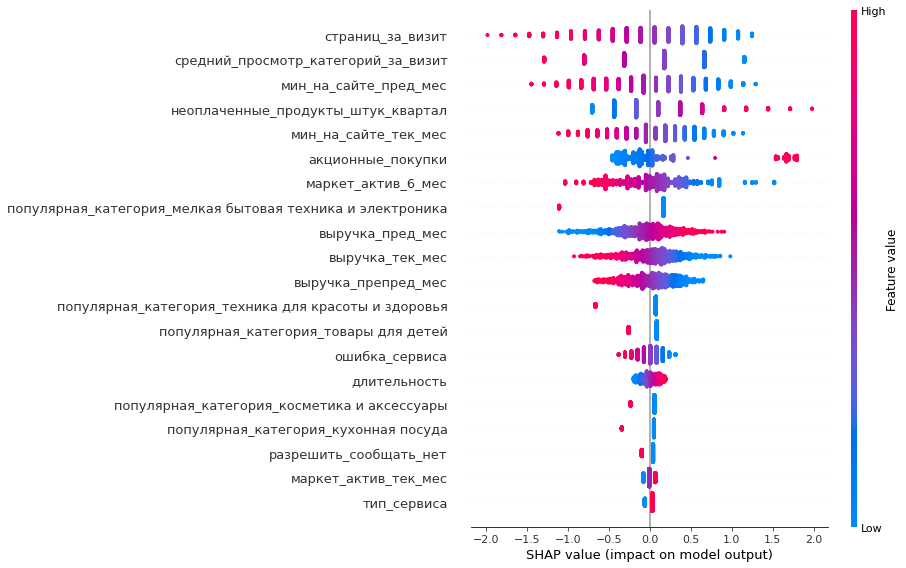

In [51]:
#Посмотрим как признаки влияют на каждое предсказание модели:
explainer = shap.LinearExplainer(model, X_train_tranformed)
shap_values = explainer(X_train_tranformed)  

shap.plots.beeswarm(shap_values, max_display=20)

 > Значения слева от центральной оси - вероятность отнесения объекта к классу 0 (Покупательская активность: неизменилась), 1 - снизилась

> Влияние на каждое предсказание модели оказывают все 20 признаков, какие-то в большей мере, какие-то в меньшей

> Из графика видно, что значения отсортированные в порядке влияния на таргет

К примеру признаки страниц за визит, минут на сайте за пред месяц, мин на сайте текущ месяц, стараются отнести модель к нулевому классу, имея большое влияние. А признак неоплаченные продукты шт квартал старается отнести модель к классу 1

> Цвет точек отражает значения каждого признака объекта: чем краснее объект, тем больше признак

### График shap.plots.waterfall

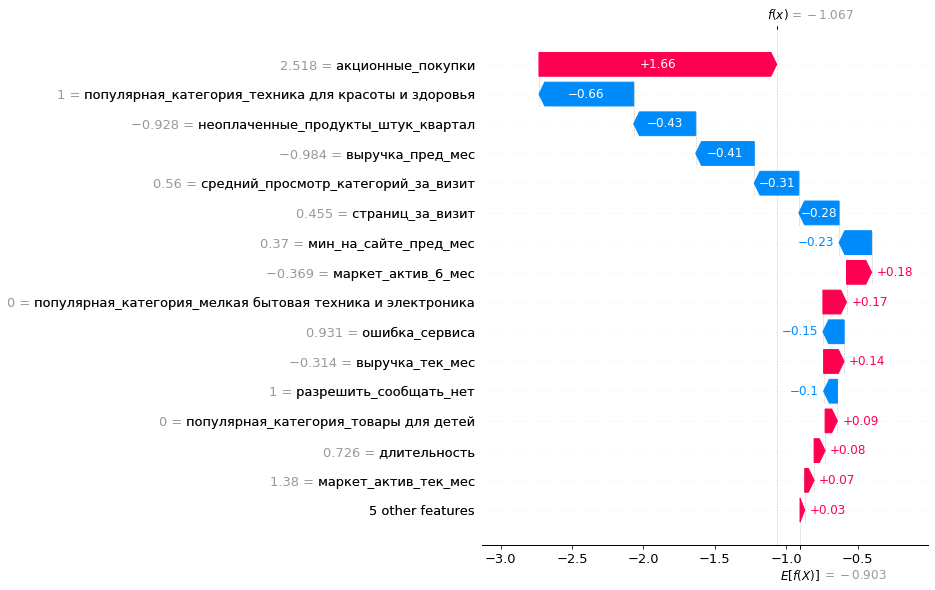

In [52]:
#Для определенного наблюдения из таблицы можно посомтреть значимость признаков таким способом:
shap.plots.waterfall(shap_values[37], max_display=16)

Диаграмма визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете. К примеру мы взяли случайное наблюдение №37, мы можем посмотреть влияние всех признаков на отнесение данного элемента к определенному классу. Из графика видно, что признак   акционные cильнее всего влияет на классификацию, он «перетягивает» предсказание в сторону класса 1. (снижение пользоват. активности)

### График shap.plots.bar

In [53]:
#Без апгрейда библиотек выдает ошибку:
!pip install shap --upgrade
!pip install matplotlib --upgrade

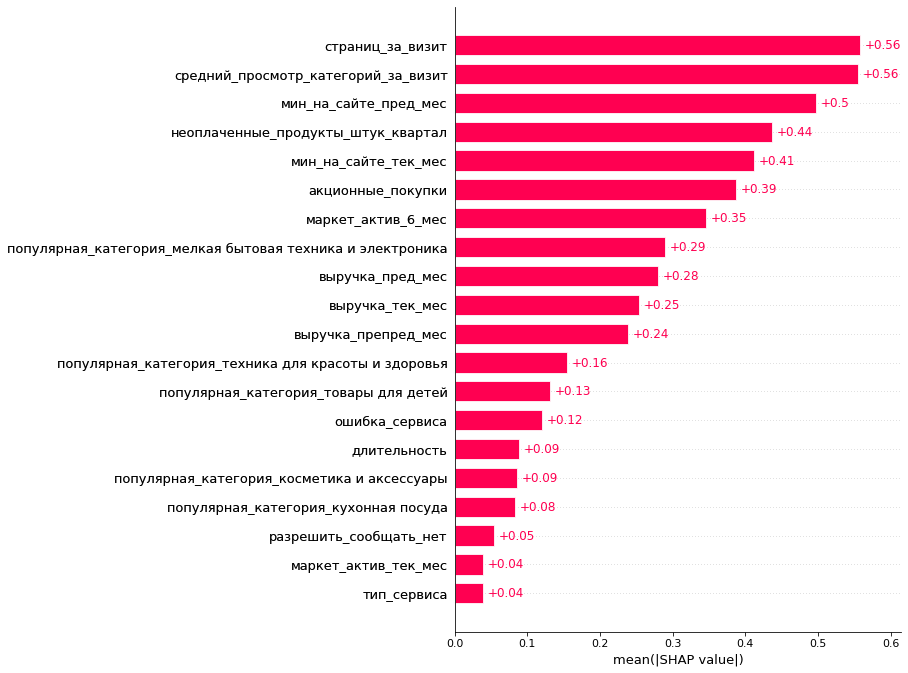

In [54]:
shap.plots.bar(shap_values, max_display=20)

Столбчатая диаграмма shap отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Для расчёта средних берут значения Шепли по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю

> Наибольший вклад среди всех признаков в прогнозирование модели вносит признак страниц за визит, после него средний просмотр категорий за визит и т.д.

### Важность признаков по коэффициентам модели

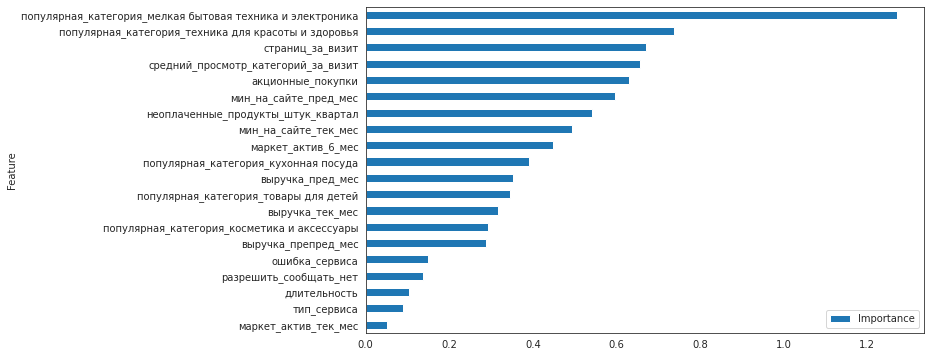

In [55]:
coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 
plt.show()

### Анализ признаков

Как видно из столбчатой диаграммы **SHAP**, наибольшее влияние оказывает признак "страниц за визит", а наименьшее влияние "тип сервиса"

---
**Слабое влияние признаков на предсказание модели оказывают:**

> признак **тип сервиса** (уровень сервиса, например «премиум» и «стандарт»), он вносит наименьшее влияние в прогнозирпование модели

> Также мало влияющий признак **длительность** (значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте), который в большей степени влияет нежели признак тип сервиса, но все равно слабо относительно других признаков

---
- **Сильное влияние признаков на предсказание модели оказывают:**

**Склоняют модель к признаку 0 (пользовательская активность - не изменилась)**:

> **страниц за визит** (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца), вносит наибольшее влиятние среди всех признаков, как по диаграмме важности, так и по shap beeswarms

> **средний просмотр категорий за визит** - второй по значимости признак

**Склоняют модель к признаку 1 (пользовательская активность - снизилась)**:

> **неоплаченные продукты штук квартал** (общее число неоплаченных товаров в корзине за последние 3 месяца.) Данный признак сильно влияет на отнесение предсказания модели к классу 1

> **акционные покупки** (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев) - Доля покупок, сделанных по акции

<a id='section_8'></a>

## Сегментация покупателей

Попробуем выделить определенные сегменты покупателей с сильной вероятность отнесения к классу 1 (покупательская активность - снизилась) и дать практические рекомендации.

Исходя из признаков, которые стараются отнести модель к 1 классу:

> рассмотрим признак **Акционные покупки**

> Выделим сегмент людей, который покупают большую часть покупок **только по акции**

> Вероятность отнесения к данному сегменту должна быть высокая

> Дадим практические рекомендации для улучшения, исходя из результатов анализа

In [56]:
#Возьмем вероятность отнесения (метки классов) лучшей модели:
best_model = randomized_search.best_estimator_
y_pred = best_model.predict_proba(X)[:, 1]

y_pred = pd.Series(y_pred)

y_pred

0       0.914185
1       0.447510
2       0.801053
3       0.962661
4       0.692409
          ...   
1291    0.039322
1292    0.065567
1293    0.263550
1294    0.146940
1295    0.654013
Length: 1296, dtype: float64

In [57]:
#Истинные значения из датасета:
y_true = y.apply(lambda x: 1 if x=='снизилась' else 0)

y_true

0       1
1       1
2       1
3       1
4       1
       ..
1291    0
1292    0
1293    0
1294    0
1295    0
Name: покупательская_активность, Length: 1296, dtype: int64

In [58]:
#Создаем датафрейм, добавляем в него истинные знаечния и вероятности отнесения к классу:
df_act = pd.DataFrame({'y_true': y_true, 'predict_proba': y_pred})

#Добавляем столбец с долей акционных покупок:
df_act['action_buy'] = df['акционные_покупки']

#Добавляем столбец id, чтобы добавить df_income:
df_act['id'] = df['id']

#Добавляем в таблицу значения прибыли по id:
df_act = pd.merge(df_act, df_income, on='id', how='inner')

#Добавим столбец с порогом 0.7 отнесения к классу 1:
df_seg = df_act.copy()

#Выводим получившуюся таблицу:
df_act

,y_true,predict_proba,action_buy,id,прибыль
0,1,0.914185,0.75,215349,4.16
1,1,0.447510,0.14,215350,3.13
2,1,0.801053,0.99,215351,4.87
3,1,0.962661,0.94,215352,4.21
4,1,0.692409,0.26,215353,3.95
...,...,...,...,...,...
1291,0,0.039322,0.24,216643,4.44
1292,0,0.065567,0.21,216644,6.11
1293,0,0.263550,0.20,216645,3.29
1294,0,0.146940,0.12,216646,4.03


In [59]:
df_act['прибыль'].describe()

count    1296.000000
mean        3.997701
std         1.011198
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

> Выделяем сегмент покупателей, с высокой вероятностью отнесения к классу 1 (зададимся порогом 0.7) и прибылью выше 4 (большая прибыль относительно данных, представленных в таблице df_income. Медианное значение, рассмотрим более половины покупателей с высокой прибылью):

In [60]:
#Выделяем сегмент:
df_seg = df_seg.query('predict_proba > 0.7 and прибыль > 4')

df_seg

,y_true,predict_proba,action_buy,id,прибыль
0,1,0.914185,0.75,215349,4.16
2,1,0.801053,0.99,215351,4.87
3,1,0.962661,0.94,215352,4.21
7,1,0.927497,0.14,215356,4.93
10,1,0.818996,0.23,215361,4.03
...,...,...,...,...,...
1204,0,0.757385,0.25,216556,4.97
1212,0,0.748036,0.94,216564,5.58
1247,0,0.775692,0.22,216599,4.06
1255,0,0.791437,0.23,216607,4.91


> Проиллюстрируем данный сегмент на диаграмме рассеяния

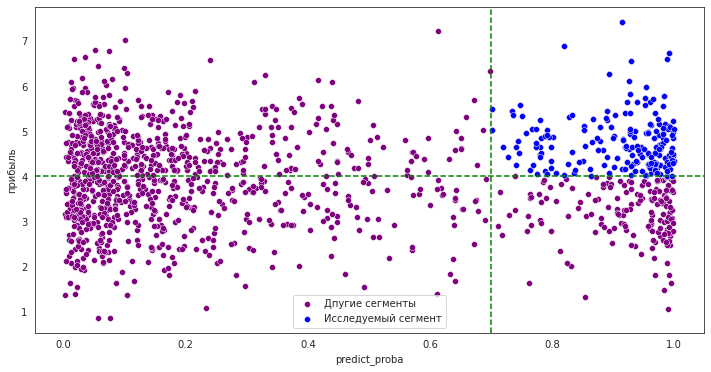

In [61]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_act, x='predict_proba', y='прибыль', label='Дпугие сегменты', color='purple')
sns.scatterplot(data=df_seg, x='predict_proba', y='прибыль', label='Исследуемый сегмент', color='blue')
plt.legend()
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=4, color='green', linestyle='--')
plt.show()

Итак, мы выделили сегмент покупателей, у которых большая вероятность отнесения к классу 1 и высокая прибыль - ***df_seg***, исключим данных клиентов по id из ***df*** от всех и посмотрим разницу между ними по расзличным факторам:

In [62]:
#Выделим из df_market по id клиентов из сегмента:
df_market_with_seg = df[df['id'].isin(df_seg['id'])]

#Исключаем данный сегмент по id из df_market:
df_market_without_seg = df[~df['id'].isin(df_seg['id'])]

У нас есть 2 сегмента покупателей, теперь можно рассмотреть распределение по различным факторам в каждом из них и сравнить между собой:

> Рассмотрим какое среднее количество страниц просматривают поситители из разных сегментов при визите на сайт:

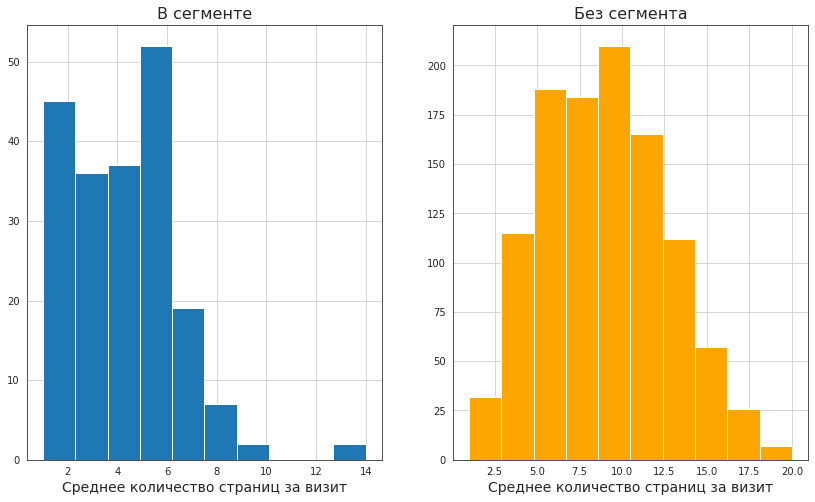

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
df_market_with_seg['страниц_за_визит'].hist(ax=axes[0])
axes[0].set_title('В сегменте', fontsize=16)
axes[0].set_xlabel('Среднее количество страниц за визит', fontsize=14)
df_market_without_seg['страниц_за_визит'].hist(color='orange', ax=axes[1])
axes[1].set_title('Без сегмента', fontsize=16)
axes[1].set_xlabel('Среднее количество страниц за визит', fontsize=14)
plt.show()

Видно, что пользователи в сегменте - редко просматривают **более 8 страниц**, в то время как у пользователей не входящих в этот сегмент просмотр может достигать и 20 страниц за один визит

> Рассмотрим какое количество времени тратят люди, входящие и не входящие в сегмент, на просмотр сайта

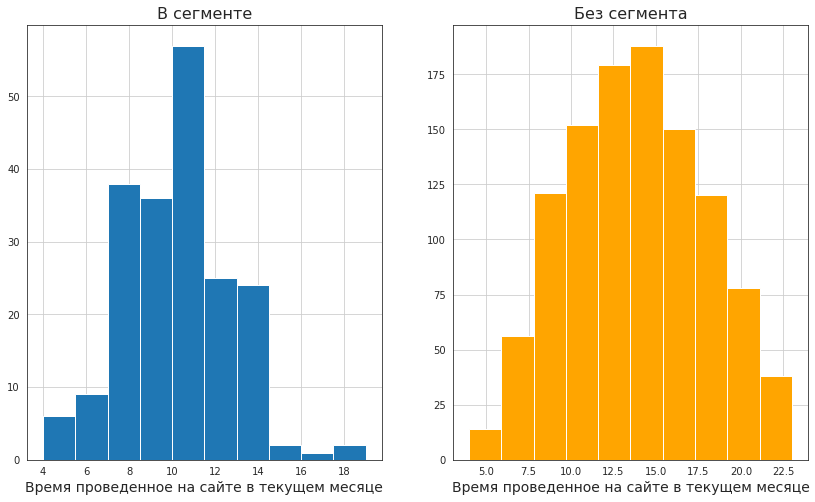

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
df_market_with_seg['мин_на_сайте_тек_мес'].hist(ax=axes[0])
axes[0].set_title('В сегменте', fontsize=16)
axes[0].set_xlabel('Время проведенное на сайте в текущем месяце', fontsize=14)
df_market_without_seg['мин_на_сайте_тек_мес'].hist(color='orange', ax=axes[1])
axes[1].set_title('Без сегмента', fontsize=16)
axes[1].set_xlabel('Время проведенное на сайте в текущем месяце', fontsize=14)
plt.show()

Рассмотрим также время проведенное на сайте в предыдущий месяц:

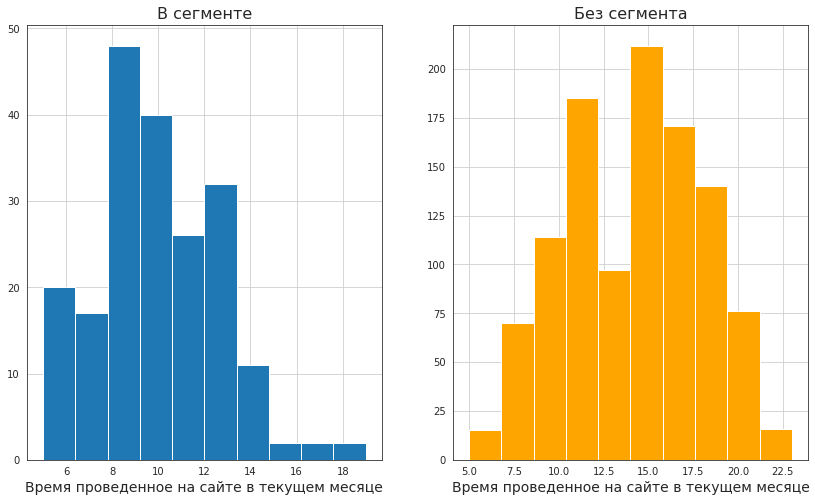

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
df_market_with_seg['мин_на_сайте_пред_мес'].hist(ax=axes[0])
axes[0].set_title('В сегменте', fontsize=16)
axes[0].set_xlabel('Время проведенное на сайте в текущем месяце', fontsize=14)
df_market_without_seg['мин_на_сайте_пред_мес'].hist(color='orange', ax=axes[1])
axes[1].set_title('Без сегмента', fontsize=16)
axes[1].set_xlabel('Время проведенное на сайте в текущем месяце', fontsize=14)
plt.show()

> Из гистограмм видно, что среднее количество проведенного на сайте в группе с сегментов - меньше, чем в группе без него

Посмотрим какие категории товаров популярны у людей в сегменте:

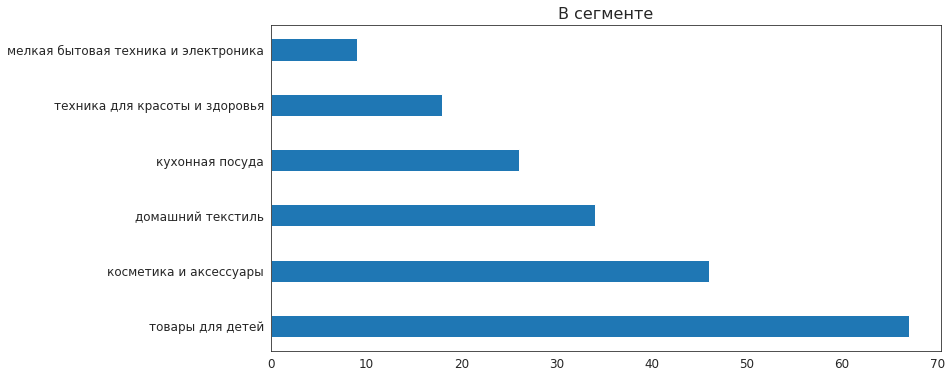

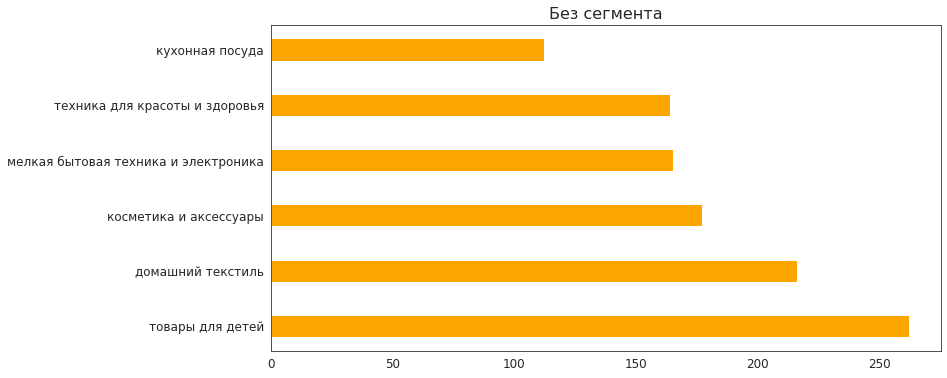

In [66]:
plt.figure(figsize=(12,6))
df_market_with_seg['популярная_категория'].value_counts().plot(kind='barh', width=0.4, fontsize=12)
plt.title('В сегменте', fontsize=16)
plt.figure(figsize=(12,6))
df_market_without_seg['популярная_категория'].value_counts().plot(kind='barh', color='orange', width=0.4, fontsize=12)
plt.title('Без сегмента', fontsize=16)
plt.show()

В обоих группах люди часто покупают товары для детей. Люди в сегменте чаще берут по акциям кухонную посуду, нежели люди, которые не входят в него. Также следует учесть, что количество электронники, продаваемой по акции - самое маленькое среди всех категорий. Рассмотрим какую долю сегмент занимает от общего числа покупателей:

In [67]:
#Процент от общего числа покупателей:
(len(df_seg)/len(df)) * 100

15.432098765432098

> **15 %** от всех покупателей, закупаются только по акциям

> Есть и положительные стороны, данные покупатели также имеют высокую прибыль (Закупаются только по акциям - но в большом объеме - на графике можно наблюдать значение прибыли почти достигающие 7)

> Данные покупатели **снижают покупательскую активность**, но приносят такую же прибыль и даже больше, относительно других клиентов

> Среднее количество просмотренных страниц за визит у покупателей в сегменте - меньше, чем не входящих в него

> Среднее время проведенной на сайте у покупателей в сегменте - меньше, чем не входящих в него

> Люди входящие в сегмент - редко берут электроннику

**Рекомендации:**

> Чтобы увеличить покупательскую активность - **нужно чаще проводить акции**, тогда клиенты, которые закупаются только по акциям - будут чаще взаимодействовать с магазином

> Увеличение числа акций, также должно положительно сказаться на доходе магазина

> Люди в сегменте меньше времени проводят на сайте и просматривают меньше страниц, возможно стоит улучшить сайт

> Возможно магазин проводит мало акций в категории товаров "мелкая бытовая техника и электронника", их количество нужно увеличить

> Возможно слишком частые акции разорят магазин, следует пересмотреть систему акционных продаж: **сделать акции чаще, но уменьшить процент (скидку) на товары во время акции**

Данные рекомендации должны помочь магазину повысить пользовательскую активность

<a id='section_9'></a>

## Общий вывод

Изначальная постановка задачи:

Отчёт магазина за прошлый период показал, что активность покупателей **начала снижаться**. Привлекать новых клиентов уже не так эффективно. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. Итак, нам поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

В качестве исходных данных были предоставлены четыре файла с форматом "*csv*":

> ***df_market*** - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении

> ***df_money*** - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом

> ***df_time*** - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода 

> ***df_income*** - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю

По исходным данным была проведена предобработка, в результате которой были обнаружены ошибки в категориальных переменных. Данные неточности были исправлены на верные значения. Также была выполнена проверка на наличие дубликатов и пропусков - их в табличных данных всех файлов не нашлось. Все количественные переменные также были проверены, все они соответсвовали требуемым типам.

Исследовательский анализ данных подтвердил, что у большенства количественных данных - **нормальное распределение**. Также была выполнена проверка категориальных данных. Построены **гистограммы частотности** и **круговые диаграммы**. По результатам графического анализа удалено одно **аномальное значени** с ненормальным значением **выручки**. Также были выделены клиенты, которые являются **активными покупателями** за последние 3 месяца.

Для поиска лучшей модели требовалость выполнить определенное количество шагов:

> Сначала мы **объединили данные** по всем таблицам (за исключение ***df_income***)

> Провели **корреляционный анализ** итогового датафрейма, мультиколлинеарности входных признаков - **не выявили**

Для получения предсказаний были использованны следующие алгоритмы МО:

> ***DecisionTreeClassifier*** - дерево решений

> ***kNN*** - количество ближайших соседей

> ***LogisticRegression*** - логистическая регресси

> ***SVC*** - метод опорных векторов

Для поиска гиперпараметров и лучшей модели был использован автоматизированный поиск по средствам ***RandomizedSearchCV***, данный способ позволяет ограничить число комбинаций гиперпараметров для поиска. Оценка моделей производилась по средсвам ***roc_auc_score** - данная метрика оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. По результатам перебора гиперпараметров, моделей, по метрике ***roc_auc*** лучшей моделью оказалась:

> Логистическая регрессия с коэффициентом регуляризации ***C***=424

Проведен анализ важности признаков, как показали **SHAP графики**, наибольшее влияние на отнесение к классу 1 (пользовательская активность - снизилась), оказывают признаки: **"акционные покупки"**, **"неоплаченные продукты штук квартал"**.

Было принято решение о сегментации клиентов, чтобы выявить из-за чего признак стремиться классифицировать клиента (отнести его) к классу 1. Признак, который было решено рассматривать **"акционные покупки"**. В Результате анализа сегментов было выявлено:


> Покупатели из сегмента меньше взаимодействуют с сайтом и реже его посещают 

> Люди в сегменте плохо покупают электроннику, возможно на данный вид продукции акционные скидки проводят реже

> Почти **15%** от всех покупателей покупают **только по акции** - что **снижает пользовательскую активность** (делают закупки в определенный период)

Для решения этой проблемы было предложено увеличить частоту акций, чтобы люди, которые закупаются только по акциям - закупались чаще, что в последсвии увеличит пользовательскую активность. Большое количество акций может принести убытки магазину, поэтому следует улучшить систему акционных продаж: **сделать акции чаще, но уменьшить процент (скидку) на товары во время акции**. Для увеличения пользовательской активности также можно пересмотреть работу сайта магазина, улучшить его с дизайнерской точки зрения и уменьшить количество сбоев. Также следует обратить внимание на определенные категории товаров таких как "электронника", возможно увеличение акции по конкретным товарам - увеличит на них спрос в рассмотренном сегменте покупателей